# Hidden Markov Models (HMMs) 

For this worksheet you will practice working with Hidden Markov Models (HMMs) with the `hmmlearn` library. More specifically, you will specify, simulate, and perform inference for HMMs; for inference you will calculating posteriors, find the most likely state, and estimate the model's hyper-parameters.

## 1.1. Specifying HMMs

Consider the example from lecture, where you have a *Fair* ($X_t=0$) and a *Biased* ($X_t=1$) coin which are indistinguishable, with probability of *Heads* ($O_t=0$) or *Tails* ($O_t=1$): 
$$ P(O_t=0|X_t=0)=0.5, \; P(O_t=1|X_t=0)=0.5 \\ P(O_t=0|X_t=1)=0.8, \; P(O_t=1|X_t=1)=0.2$$
Furthermore, after each flip there is a 5% probability of switching coins: 
$$ P(X_t=0|X_{t-1}=0)=0.95, \; P(X_t=1|X_{t-1}=0)=0.05 \\ P(X_t=0|X_{t-1}=1)=0.05, \; P(X_t=1|X_{t-1}=1)=0.95$$
and the  probability distribution of the initial coin is is 
$$P(X_1=0)=P(X_1=1)=0.5$$

This model involves only discrete variables, and can be specified using `hmmlearn.hmm.CategoricalHMM()`. The three relevant parameters are: the initial state probs ($P(X_1=i)$), the *transition matrix* ($P(X_t=j|X_{t-1}=i)$), and the *emissions probs* ($P(O_t=j|X_t=i)$). The following below specifies this model:

In [1]:
#!pip install hmmlearn # run once if hmmlearn is not installed
from hmmlearn import hmm; import numpy as np

# our model has two components (hidden states): the fair and biased coin
gen_model = hmm.CategoricalHMM(n_components=2, random_state=123)

# these are the initial state probabilities (fair=0, biased=1) 
gen_model.startprob_ = np.array([0.5, 0.5])

# this is the transition matrix 
gen_model.transmat_ = np.array([[0.95, 0.05],
                                [0.05, 0.95]])
# and the emission matrix:
gen_model.emissionprob_ = np.array([[0.5, 0.5],
                                    [0.8, 0.2]])
gen_model

CategoricalHMM(n_components=2, random_state=123)

## 1.2. Simulating from HMMs

Once you have specified a model, you can use it to simulate sequences of values from the HMM with the `sample()` method.

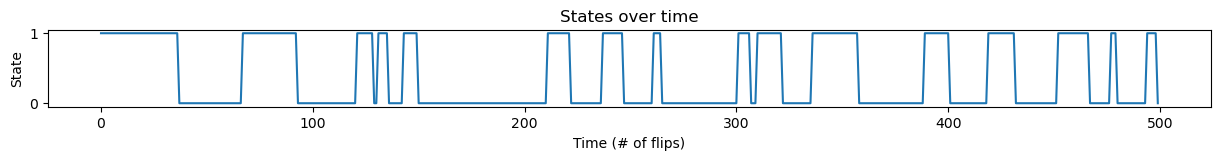

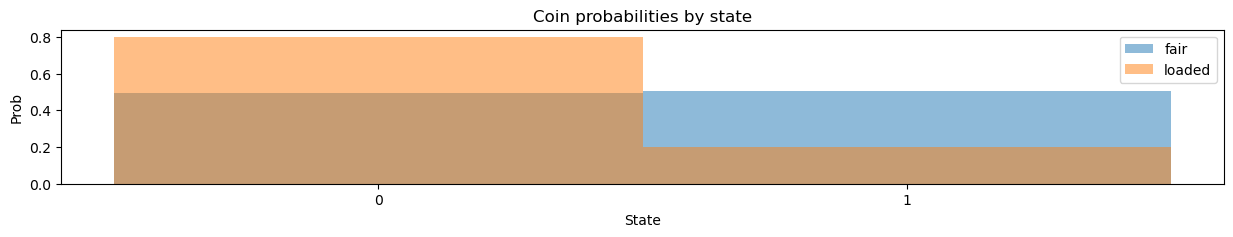

In [2]:
# simulate the loaded dice rolls
rolls, gen_states = gen_model.sample(30000)

import matplotlib.pyplot as plt

# plot first 500 states
fig, ax = plt.subplots(figsize=(15, 1));ax.plot(gen_states[:500])
ax.set_title('States over time');ax.set_xlabel('Time (# of flips)');ax.set_ylabel('State');

# plot histograms of emmission probs for hidden states
fig, ax = plt.subplots(figsize=(15, 2))
ax.hist(rolls[gen_states == 0], label='fair', alpha=0.5, bins=np.arange(3) - 0.5, density=True)
ax.hist(rolls[gen_states == 1], label='loaded', alpha=0.5, bins=np.arange(3) - 0.5, density=True)
ax.set_xticks(ticks=[0,1])
ax.set_title('Coin probabilities by state');ax.set_xlabel('State');ax.set_ylabel('Prob');ax.legend();

## 1.3. Inference for HMMs

### 1.3.1. Posterior Probabilities

You can calculate the posterior *log-likelihood* ($\log p(\mathbf{o}_{1:n})$) of a sample with the `score()` method, and the posterior marginal ($ p(x_t|\mathbf{o}_{1:n})$)  of each state with the `predict_proba()` method.
The following code replicates the calculations from the example in class with $\mathbf{o}_{1:4} = (0,0,1,0) =(H,H,T,H)$

In [3]:
# specify observed sample as (n x 1) vector
o_1tN = np.array([0,0,1,0]).reshape(-1, 1)
print( o_1tN )

[[0]
 [0]
 [1]
 [0]]


In [4]:
# calculate the posterior log-likelihood (log evidence) 
log_evidence = gen_model.score( o_1tN ) ; evidence = np.exp( log_evidence )
print( f"log-evidence = {log_evidence} \n evidence = {evidence}" )

log-evidence = -2.4843227452934147 
 evidence = 0.08338200624999997


In [5]:
# calculate the posterior distribution of each X_1:X_n (here X1:X4)
# the ith row represents probabilities P(X_i=0|observations) and P(X_i=1|observations)

posterior_probs = gen_model.predict_proba(o_1tN)
print(f"Posterior Probabilities:\n{posterior_probs}")

# Find the most likely sequence of hidden states
hidden_states = gen_model.predict(o_1tN)
print(f"Most Likely Hidden States: {hidden_states}")

Posterior Probabilities:
[[0.37899851 0.62100149]
 [0.38984618 0.61015382]
 [0.42620969 0.57379031]
 [0.4113796  0.5886204 ]]
Most Likely Hidden States: [1 1 1 1]


Recall $\hat{f}_t = p(x_t|\mathbf{o}_{1:t} ) $ and $f_t = p(x_t, \mathbf{o}_{1:t} )  $

E.g. You can verify the first forward factor ($\hat{f}_1 = p(x_1|o_1=0) =[ 5/12 \;\; 8/13]^\top$) as:

In [6]:
gen_model.predict_proba( np.array([0]).reshape(-1, 1))

array([[0.38461538, 0.61538462]])

### 1.3.2. Maximum-a-posteriori Sequence

You can find the most likely sequence of hidden states with the `decode()/predict()` methods. Both methods use the [Viterbi algorithm](https://en.wikipedia.org/wiki/Viterbi_algorithm) (dynamic programming) by default, but decode also returns the maximum score (log-posterior probability $\log p(\mathbf{x}_{1:n}|\mathbf{o}_{1:n}))$.

In [7]:
o_1tN = np.array([0,0,1,0]).reshape(-1, 1)
log_prob, hidden_states = gen_model.decode(o_1tN)
print(f"Log probability / max score: {log_prob}") # Log probability of the best hidden state sequence
print(f"Most likely states: {hidden_states}") # The most likely sequence of hidden states

Log probability / max score: -3.125895630099327
Most likely states: [1 1 1 1]


In [8]:
gen_model.predict(o_1tN)

array([1, 1, 1, 1])

### 1.3.3. Hyper-parameter Selection / Model fitting

You can also *estimate* the HMM's parameters (initial, transition, & emission probs) with the `fit()` method. This uses *approximate* evidence maximization via the [Baum-Welch algorithm](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm), a variant of the Expectation Maximization (EM) algorithm. Because the algorithm can get stuck on a local minimum, we will fit it #44 times from random initial parameter values, and select the best solution on a validation set as our final model.


In [9]:
from hmmlearn import hmm; import numpy as np
rolls_sampled, gen_states = gen_model.sample(30000); sampled_DATA = rolls_sampled

# INPUT - Define the split ratio
train_ratio = 0.5 # Train data (= train_ratio); Validation data (= 1- train_ratio)
split_index = int(sampled_DATA.shape[0] * train_ratio)
X_train = sampled_DATA[:split_index]; X_validate = sampled_DATA[split_index:]

best_score = best_model = None; np.random.seed(1234)
n_fits = 44; Num_HiddenStates = 2 # INPUT - number of hidden states

for idx in range(n_fits):
    # Specify Categorical HMM with 2 states, and 
    # initialize starting (s), transition (t) and emission (e) probs ('ste')
        model = hmm.CategoricalHMM( n_components= Num_HiddenStates, init_params='ste')  
    # run the Baum-Welch algorithm
        model.fit(X_train)
    # compute log probability under the model
        score = model.score(X_validate) 
    # print(f'Model #{idx}\tScore: {score}')
        if best_score is None or score > best_score:
            best_model = model
            best_score = score

# check optimal score from true model (params that generated the data)
gen_score = gen_model.score(X_validate)
print(f'Generated score: {gen_score} \n Best score: {best_score}')

Generated score: -9552.302872232804 
 Best score: -9553.36319588863


We can check the fitted model hyper-parameters, which are pretty close to the true ones:

In [10]:
print( f'fitted starting probs: \n {best_model.startprob_}')
print( f'fitted transition probs:\n {best_model.transmat_}')
print(f'fitted emission probs: \n {best_model.emissionprob_}')

fitted starting probs: 
 [5.11046899e-10 9.99999999e-01]
fitted transition probs:
 [[0.94681262 0.05318738]
 [0.05896793 0.94103207]]
fitted emission probs: 
 [[0.50274071 0.49725929]
 [0.81832226 0.18167774]]


In [11]:
true_model = gen_model
print( f'True starting probs: \n {true_model.startprob_}')
print( f'True transition probs:\n {true_model.transmat_}')
print(f'True emission probs: \n {true_model.emissionprob_}')

True starting probs: 
 [0.5 0.5]
True transition probs:
 [[0.95 0.05]
 [0.05 0.95]]
True emission probs: 
 [[0.5 0.5]
 [0.8 0.2]]


## 2. Example

Consider the following HMM, This model has a binary hidden state representing the daily weather (Hot vs Cold), and the observed variable is how many ice-creams a person eats (1, 2, or 3). 
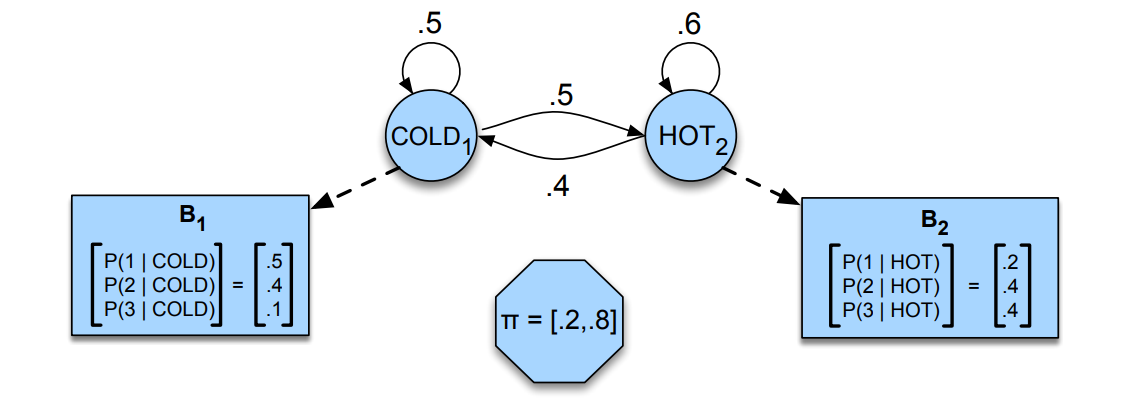

Repeat the previous analysis for this model:
- Specify the model in HMM learn
- Simulate 1,000 observations from it
- Find the log-evidence of the first 100 observations
- Find the most likely hidden state sequence of the first 100 observations, plot it against the true (simulated) states
- Split the data 50/50 into a training & validation set, and estimate the model hyperparameters as above; compare your estimates to the true parameters

In [12]:
# Specify the model in HMM learn
weather_model = hmm.CategoricalHMM(n_components=2, random_state=123)

# Initial state probabilities; state 0 = Cold, state 1 = Hot
weather_model.startprob_ = np.array([0.2, 0.8])

# Transition matrix
weather_model.transmat_ = np.array([[0.5, 0.5],
                                    [0.4, 0.6]])
# Emission matrix
weather_model.emissionprob_ = np.array([[0.5, 0.4, 0.1],
                                        [0.2, 0.4, 0.4]])
weather_model

CategoricalHMM(n_components=2, random_state=123)

log-evidence of the first 66 observations: -69.0286303372449
evidence = 1.0501389120154067e-30
Most likely states: [1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 0 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0]
True states: [1 0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 1
 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1]


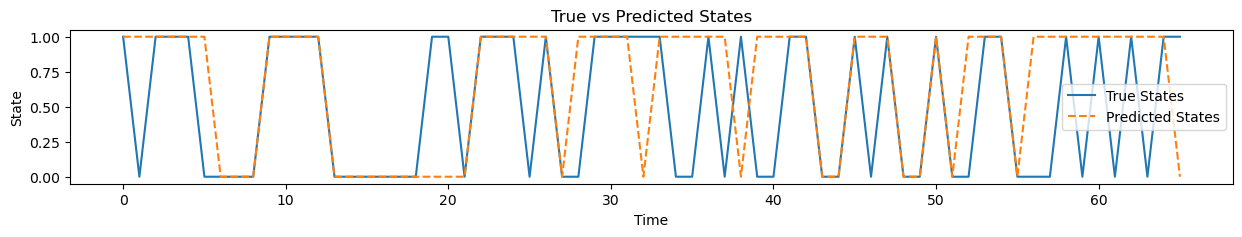

In [13]:
# Simulate 1,000 observations from it
obs_sampled, states = weather_model.sample(1000)

# Find the log-evidence of the first 66 observations
log_evidence = weather_model.score(obs_sampled[:66])
print(f"log-evidence of the first 66 observations: {log_evidence}"); print( f"evidence = {np.exp(log_evidence)}" )

# Find the most likely hidden state sequence of the first 66 observations
predicted_states = weather_model.predict(obs_sampled[:66]); print("Most likely states:",predicted_states)

# Plot the true states and predicted states
true_states = states[:66]; print("True states:",true_states)

plt.figure(figsize=(15, 2)); plt.plot(true_states, label='True States')
plt.plot(predicted_states, label='Predicted States', linestyle='--'); plt.legend(); plt.xlabel('Time'); 
plt.ylabel('State'); plt.title('True vs Predicted States'); plt.show()


In [14]:
obs_sampled, states = weather_model.sample(1000)

# INPUT - Define the split ratio
train_ratio = 0.5 # Train data (= train_ratio); Validation data (= 1- train_ratio)
split_index = int(obs_sampled.shape[0] * train_ratio)
X_train = obs_sampled[:split_index]; X_validate = obs_sampled[split_index:]

# Estimate the model hyperparameters
best_score = best_model = None; np.random.seed(1234)
n_fits = 50; Num_HiddenStates = 2 # INPUT- number of hidden states

for idx in range(n_fits):
    model = hmm.CategoricalHMM(n_components= Num_HiddenStates, init_params='ste')
    model.fit(X_train); score = model.score(X_validate)
    if best_score is None or score > best_score:
        best_model = model; best_score = score

print(f'Best score: {best_score}')

# Compare your estimates to the true parameters
print(f'True starting probs: {weather_model.startprob_}'); print(f'Fitted starting probs: {best_model.startprob_}')
print(f'True transition probs: {weather_model.transmat_}'); print(f'Fitted transition probs: {best_model.transmat_}')
print(f'True emission probs: {weather_model.emissionprob_}');print(f'Fitted emission probs: {best_model.emissionprob_}')

Best score: -550.0884166718336
True starting probs: [0.2 0.8]
Fitted starting probs: [9.99911688e-01 8.83123194e-05]
True transition probs: [[0.5 0.5]
 [0.4 0.6]]
Fitted transition probs: [[0.76000517 0.23999483]
 [0.75034798 0.24965202]]
True emission probs: [[0.5 0.4 0.1]
 [0.2 0.4 0.4]]
Fitted emission probs: [[0.4028619  0.47147576 0.12566234]
 [0.08505293 0.22555509 0.68939197]]
